In [ ]:
---
title: Modelowanie część 3 i 4
authors: Paweł Bucior, Julia Witek
description: Frontend do modelowania biznesowego
params:
    file_name:
        input: file
        label: Upload file to generate BPMN model
---

# Odkrywanie modeli procesów w BPMN przy użyciu dostosowanego do notacji BPMN algorytmu Alpha Miner

Na tym etapie projektu omówimy proste rozwiązanie z zakresu odkrywania modeli procesów -- na potrzeby zrozumienia sposobu odkrywania bram zastosujemy nieco zmieniony algorytm Alpha przystosowany do odkrywania modeli w notacji BPMN.

Elementy tego rozwiązania powinny zostać zintegrowane z rozwiązaniem z poprzednich ćwiczeń.

## Konfiguracja środowiska

Przed implementacją potrzebujemy jeszcze odpowiednie środowisko:

In [1]:
!pip install opyenxes
!apt install libgraphviz-dev
!pip install pygraphviz

     |████████████████████████████████| 94 kB 2.8 MB/s 
  Created wheel for opyenxes: filename=opyenxes-0.3.0-py2.py3-none-any.whl size=79230 sha256=a06abb1cfcd19b064b5c4712e95c14018b845a2b96a7d3d7046670b652538447
  Stored in directory: /root/.cache/pip/wheels/b2/0b/80/cb6b1a80882eff1d3707d9b30ca5febe120d7fa0120e38e69b
Successfully built opyenxes
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 

In [ ]:
file_name="file"

In [2]:
import pygraphviz as pgv
from itertools import product
from collections import defaultdict
from typing import Dict, Set
from IPython.display import Image, display

## Przykładowy log dla zrozumienia działania algorytmu

Rozważmy następujące ślady (warianty) pewnego dziennika zdarzeń:

```
a b c d e g
a b c d f g 
a c b d e g
a c b d f g
```

Dla takiego zbioru wariantów, w oparciu o algorytm Alpha, możemy znaleźć następujące relacje (x,y — zdarzenia):

* (>) **następstwo bezpośrednie**: x>y jeśli w dowolnym wariancie bezpośrednim następstwem zdarzenia x jest zdarzenie y,
* (→) **przyczynowość**: x→y iff x>y & not y>x,
* (||) **potencjalna równoległość**: x||y iff x>y & y>x,
* (#) **wybór/niepowiązanie/brak bezpośredniego następstwa**: x#y iff not x>y & not y>x.

W naszej implementacji nie musimy używać bezpośrednio relacji **brak bezpośredniego następstwa**, gdyż zamiast tego wystarczy sprawdzić, czy dane zdarzenia nie są w jednej z relacji: **przyczynowość** lub **potencjalna równoległość**.

In [3]:
events = """b c d e 
b c e d 
a c d e 
a c e d 
"""

events_tab = []
for line in events.splitlines():
    events_tab.append(line.split())
    
print(events_tab)


[['b', 'c', 'd', 'e'], ['b', 'c', 'e', 'd'], ['a', 'c', 'd', 'e'], ['a', 'c', 'e', 'd']]



## Manualne określenie relacji

Analogicznie jak na poprzednim laboratorium należy określić zbiory zdarzeń początkowych oraz końcowych:

In [4]:
start_set_events = {'a', 'b'}
end_set_events = {'d','e'}

In [5]:
def get_start_set_events(events_tab):
  start_set_events = set()
  for line in events_tab:
    start_set_events.add(line[0])
  
  return start_set_events

In [6]:
def get_end_set_events(events_tab):
  end_set_events = set()
  for line in events_tab:
    end_set_events.add(line[len(line)-1])
  
  return end_set_events

In [7]:
start_set_events = get_start_set_events(events_tab)
end_set_events = get_end_set_events(events_tab)

Następnie określimy relacje, tak jak zdefiniowano w algorytmie Alpha:

In [8]:

direct_succession = {
    'a': {'b','c'},
    'b': {'c','d'},
    'c': {'b','d'},
    'd': {'e','f'},
    'e': {'g'},
    'f': {'g'},
    'g': {}
}

causality = {
    'a': {'b', 'c'},
    'b': {'d'},
    'c': {'d'},
    'd': {'e','f'},
    'e': {'g'},
    'f': {'g'}
}

parallel_events = {('b', 'c'), ('c', 'b')}
type(parallel_events)

set

In [9]:
def get_direct_successtion(events):
  direct_new = {}
  unique_elements = []
  for r in events:
   for c in r:
      if c not in unique_elements:
        unique_elements.append(c)
  
  for ue in unique_elements:
    relations = set()
    for r in events:
      for index, c in enumerate(r):
        if c == ue and int(len(r)) > int(index+1):
          relations.add(r[index+1])
    if len(relations) > 0:
      direct_new[ue] = relations
    else: 
      direct_new[ue] = {}
  return direct_new

In [10]:
events = [['a', 'b', 'c', 'd', 'e', 'g'],['a', 'b', 'c', 'd', 'f', 'g'],['a', 'c', 'b', 'd', 'e', 'g'],['a', 'c', 'b', 'd', 'f', 'g']]
direct_succession = get_direct_successtion(events)
for r in direct_succession:
  print(r + ': ' + str(direct_succession[r]))

a: {'b', 'c'}
b: {'d', 'c'}
c: {'d', 'b'}
d: {'f', 'e'}
e: {'g'}
g: {}
f: {'g'}


In [11]:
events = [['a', 'b', 'c', 'd', 'e', 'h', 'i', 'k'], 
          ['a', 'b', 'd', 'c', 'e', 'h', 'j', 'k'], 
          ['a', 'f', 'g', 'h', 'i', 'k']]
direct_succession = get_direct_successtion(events)
for r in direct_succession:
  print(r + ': ' + str(direct_succession[r]))


a: {'f', 'b'}
b: {'d', 'c'}
c: {'e', 'd'}
d: {'e', 'c'}
e: {'h'}
h: {'j', 'i'}
i: {'k'}
k: {}
j: {'k'}
f: {'g'}
g: {'h'}


In [12]:
events = [['b', 'c', 'd', 'e'], 
['b', 'c', 'e', 'd'],
['a', 'c', 'd', 'e'], 
['a', 'c', 'e', 'd']]
direct_succession = get_direct_successtion(events)
for r in direct_succession:
  print(r + ': ' + str(direct_succession[r]))


# =======A1=======

b: {'c'}
c: {'e', 'd'}
d: {'e'}
e: {'d'}
a: {'c'}


Na bazie powyższych relacji oraz poniższych wzorców postaramy się zbudować model procesu w notacji BPMN:
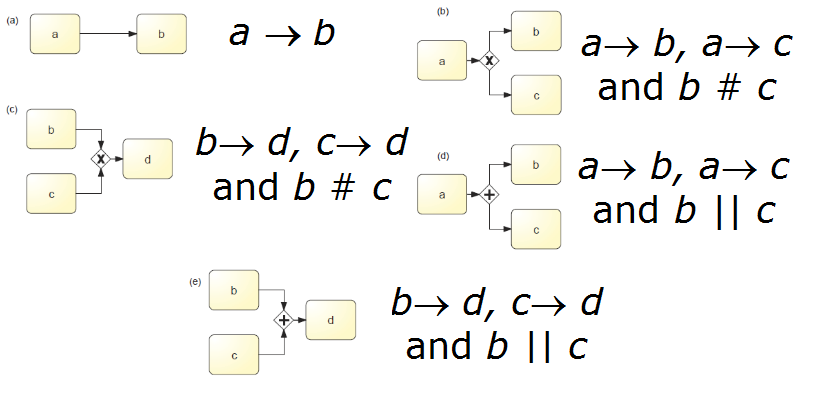


Na potrzeby naszej implementacji możemy również zdefiniować odwróconą przyczynowość dla tych zdarzeń w relacji przyczynowości, które mają wspólną przyczynę (nie jest to część samego algorytmu alfa, ale może być pomocne jako zmienna tymczasowa przy korzystaniu z wzorców alfa mining):

In [13]:
def get_causality(direct_succession) -> Dict[str, Set[str]]:
    causality = defaultdict(set)
    for ev_cause, events in direct_succession.items():
        for event in events:
            if ev_cause not in direct_succession.get(event, set()):
                causality[ev_cause].add(event)
    return dict(causality)

In [14]:
def get_potential_parallelism(direct_succession) -> Dict[str, Set[str]]:
  potential_parallelism = {}
  for ev_cause, events in direct_succession.items():
    for event in events:
      if ev_cause in direct_succession.get(event, set()):
        potential_parallelism = {(ev_cause,event), (event,ev_cause)}
        return potential_parallelism



In [15]:
potential_paralleslism = get_potential_parallelism(direct_succession)
parallel_events = potential_paralleslism
print(parallel_events)

{('d', 'e'), ('e', 'd')}


In [16]:
causality = get_causality(direct_succession)
causality

{'a': {'c'}, 'b': {'c'}, 'c': {'d', 'e'}}

In [17]:
def get_inv_causality(causality) -> Dict[str, Set[str]]:
    inv_causality = defaultdict(set)
    for key, values in causality.items():
        for value in values: 
          inv_causality[value].add(key)
    return {k: v for k, v in inv_causality.items() if len(v) > 1}

In [18]:
inv_causality = get_inv_causality(causality)
inv_causality

{'c': {'a', 'b'}}

## Wyświetlenie prostego modelu BPMN

Poniżej zaprezentowano przykładowy kod umożliwiający wyświetlenie modelu z użyciem podstawowych elementów BPMN:

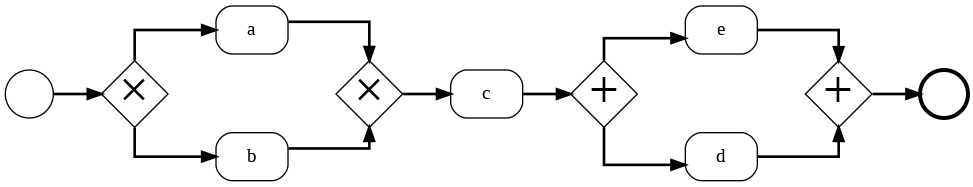

In [19]:
class MyGraph(pgv.AGraph):
 
    def __init__(self, *args):
        super(MyGraph, self).__init__(strict=False, directed=True, *args)
        self.graph_attr['rankdir'] = 'LR'
        self.node_attr['shape'] = 'Mrecord'
        self.graph_attr['splines'] = 'ortho'
        self.graph_attr['nodesep'] = '0.8'
        self.edge_attr.update(penwidth='2')
 
    def add_event(self, name):
        super(MyGraph, self).add_node(name, shape="circle", label="")

    def get_node(self,name):
        return super(MyGraph, self).get_node(name)

    def get_edges(self):
        return super(MyGraph, self).edges()
 
    def add_end_event(self, name):
        super(MyGraph, self).add_node(name, shape="circle", label="",penwidth='3')

    def add_and_gateway(self, *args):
        super(MyGraph, self).add_node(*args, shape="diamond",
                                  width=".7",height=".7",
                                  fixedsize="true",
                                  fontsize="40",label="+")
 
    def add_xor_gateway(self, *args, **kwargs):
        super(MyGraph, self).add_node(*args, shape="diamond",
                                  width=".7",height=".7",
                                  fixedsize="true",
                                  fontsize="40",label="×")
    def add_xor_inclusive_gateway(self, *args, **kwargs):
        super(MyGraph, self).add_node(*args, shape="diamond",
                                  width=".7",height=".7",
                                  fixedsize="true",
                                  fontsize="40",label="o")
        
    def add_event_gateway(self, source, targets, *args):
        gateway = 'EVENTs '+str(source)+'->'+str(targets)        
        self.add_xor_inclusive_gateway(gateway,*args)
        super(MyGraph, self).add_edge(source, gateway)
        for target in targets:
            super(MyGraph, self).add_edge(gateway, target)
 
    def add_and_split_gateway(self, source, targets, *args):
        gateway = 'ANDs '+str(source)+'->'+str(targets)        
        self.add_and_gateway(gateway,*args)
        super(MyGraph, self).add_edge(source, gateway)
        for target in targets:
            super(MyGraph, self).add_edge(gateway, target)
 
    def add_xor_split_gateway(self, source, targets, *args):
        gateway = 'XORs '+str(source)+'->'+str(targets) 
        self.add_xor_gateway(gateway, *args)
        super(MyGraph, self).add_edge(source, gateway)
        for target in targets:
            super(MyGraph, self).add_edge(gateway, target)
 
    def add_event_merge_gateway(self, sources, target, *args):
        gateway = 'EVENTm '+str(sources)+'->'+str(target)
        self.add_xor_inclusive_gateway(gateway,*args)
        super(MyGraph, self).add_edge(gateway,target)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway)

    def add_and_merge_gateway(self, sources, target, *args):
        gateway = 'ANDm '+str(sources)+'->'+str(target)
        self.add_and_gateway(gateway,*args)
        super(MyGraph, self).add_edge(gateway,target)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway)
 
    def add_xor_merge_gateway(self, sources, target, *args):
        gateway = 'XORm '+str(sources)+'->'+str(target)
        self.add_xor_gateway(gateway, *args)
        super(MyGraph, self).add_edge(gateway,target)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway)

    def add_xor_to_and_gateway(self, sources, targets, *args):
        gateway_xor = 'XORm '+str(sources)+'->'+str(targets)
        gateway_and = 'ANDs '+str(sources)+'->'+str(targets)
        self.add_xor_gateway(gateway_xor, *args)
        self.add_and_gateway(gateway_and, *args)
        super(MyGraph, self).add_edge(gateway_xor,gateway_and)
        for source in sources:
            super(MyGraph, self).add_edge(source, gateway_xor)
        for target in targets:
            super(MyGraph, self).add_edge(gateway_and, target)

G = MyGraph()

# adding start event
G.add_event("start")
if len(start_set_events) > 1:
    if tuple(start_set_events) in parallel_events: 
        G.add_and_split_gateway("start",start_set_events)
    else:
        G.add_xor_split_gateway("start",start_set_events)
else: 
    G.add_edge("start",list(start_set_events)[0])

# adding split gateways based on causality
for event in causality:
    if len(causality[event]) > 1:
        if tuple(causality[event]) in parallel_events:        
            G.add_and_split_gateway(event,causality[event])
        else:
            G.add_xor_split_gateway(event,causality[event])
 
# adding merge gateways based on inverted causality
for event in inv_causality:
    if len(inv_causality[event]) > 1:
        if tuple(inv_causality[event]) in parallel_events:
            G.add_and_merge_gateway(inv_causality[event],event)
        else:
            G.add_xor_merge_gateway(inv_causality[event],event)
    elif len(inv_causality[event]) == 1:
        source = list(inv_causality[event])[0]
        G.add_edge(source,event)

# adding end event
G.add_end_event("end")
if len(end_set_events) > 1:
    if tuple(end_set_events) in parallel_events: 
        G.add_and_merge_gateway(end_set_events,"end")
    else:
        G.add_xor_merge_gateway(end_set_events,"end")    
else: 
    G.add_edge(list(end_set_events)[0],"end")

G.draw('simple_process_model.png', prog='dot')
display(Image('simple_process_model.png'))

In [26]:
def get_start_set_events(events_tab):
  start_set_events = set()
  for line in events_tab:
    start_set_events.add(line[0])
  
  return start_set_events


def get_end_set_events(events_tab):
  end_set_events = set()
  for line in events_tab:
    end_set_events.add(line[len(line)-1])
  
  return end_set_events

def get_direct_successtion(events):
  direct_new = {}
  unique_elements = []
  for r in events:
   for c in r:
      if c not in unique_elements:
        unique_elements.append(c)
  unique_elements = sorted(unique_elements)
  for ue in unique_elements:
    relations = set()
    for r in events:
      for index, c in enumerate(r):
        if c == ue and int(len(r)) > int(index+1):
          relations.add(r[index+1])
    if len(relations) > 0:
      direct_new[ue] = relations
    else: 
      direct_new[ue] = {}
      
  return direct_new


def get_causality(direct_succession) -> Dict[str, Set[str]]:
    causality = defaultdict(set)
    for ev_cause, events in direct_succession.items():
        for event in events:
            if ev_cause not in direct_succession.get(event, set()):
                causality[ev_cause].add(event)

    return dict(causality)


def get_potential_parallelism(direct_succession) -> Dict[str, Set[str]]:
  potential_parallelism = []
  for ev_cause, events in direct_succession.items():
    tmp = []
    for event in events:
      if ev_cause in direct_succession.get(event, set()):
        if ev_cause not in tmp:
          tmp.append(ev_cause)
        tmp.append(event)
        
    if len(tmp) > 0:
      potential_parallelism.append(tuple(tmp))  
  if len(potential_parallelism) > 0:
    potential_parallelism.append(tuple(sorted(potential_parallelism[0]))) 

  return potential_parallelism


def get_inv_causality(causality) -> Dict[str, Set[str]]:
    inv_causality = defaultdict(set)
    for key, values in causality.items():
        for value in values: 
          inv_causality[value].add(key)
          
    return {k: v for k, v in inv_causality.items() if len(v) > 1}

In [34]:
def draw_graph(events):

  events_tab = []
  for line in events.splitlines():
      events_tab.append(line.split())

  start_set_events = get_start_set_events(events_tab)
  end_set_events = get_end_set_events(events_tab)
  direct_succession = get_direct_successtion(events_tab)
  parallel_events = get_potential_parallelism(direct_succession)
  causality = get_causality(direct_succession)
  inv_causality = get_inv_causality(causality)

  G = MyGraph()

  # adding start event
  G.add_event("start")
  if len(start_set_events) > 1:
      if tuple(start_set_events) in sorted(parallel_events): 
          G.add_and_split_gateway("start",start_set_events)

      else:
          G.add_xor_split_gateway("start",start_set_events)
  else: 
      G.add_edge("start",list(start_set_events)[0])

  # adding split gateways based on causality
  for event in causality:
      if len(causality[event]) > 1 and tuple(causality[event]) != tuple(inv_causality.keys()):
          if tuple(causality[event]) in parallel_events:    
              
              to_check = list(causality[event])
              is_event = False
              for eventeee in events_tab:
                if len(to_check) != len(list(set(sorted(to_check)).intersection(sorted(set(eventeee))))):
                  is_event = True
       
              if is_event:
                G.add_event_gateway(event,causality[event])
              else: 
                G.add_and_split_gateway(event,causality[event])           
          else:
              G.add_xor_split_gateway(event,causality[event])

  # adding merge gateways based on inverted causality
  for event in inv_causality:
      if len(inv_causality[event]) > 1 and tuple(sorted(inv_causality[event])) != tuple(sorted(causality.keys())):
          if tuple(inv_causality[event]) in parallel_events:
              to_check = list(inv_causality[event])
              is_event = False
              for eventeee in events_tab:
                if len(to_check) != len(list(set(sorted(to_check)).intersection(sorted(set(eventeee))))):
                  is_event = True
              
              if is_event:
                G.add_event_merge_gateway(inv_causality[event],event)
              else: 
                G.add_and_merge_gateway(inv_causality[event],event)

          else:
              G.add_xor_merge_gateway(inv_causality[event],event)
      elif len(inv_causality[event]) == 1:
          source = list(inv_causality[event])[0]
          G.add_edge(source,event)

  xor_merge_gateways = set()
  for event in inv_causality:
    if (len(inv_causality[event]) > 1 and tuple(sorted(inv_causality[event])) == tuple(sorted(causality.keys()))):
      xor_merge_gateways.add(tuple(sorted(inv_causality[event])))

  # print(xor_merge_gateways)
  for create_gateway_event in xor_merge_gateways:
     G.add_xor_to_and_gateway(inv_causality[event],tuple(inv_causality.keys()))

  end_to_delete = False
  for end_event in end_set_events:
      for start_event in start_set_events:
        try:
          if tuple(causality[end_event]) == tuple(start_event):
            G.add_xor_split_gateway(end_event, (start_event,"end"))
            end_to_delete = True
        except:
          print('Except')

  # adding end event
  G.add_end_event("end")
  if len(end_set_events) > 1 and end_to_delete == False:
      if tuple(end_set_events) in parallel_events: 
          G.add_and_merge_gateway(end_set_events,"end")
      else:
          G.add_xor_merge_gateway(end_set_events,"end")    
  elif end_to_delete == False: 
      G.add_edge(list(end_set_events)[0],"end")

  add_edges_list = []
  for sucession in direct_succession:
    found_count = 0
    for test in direct_succession:
      if test != sucession:
        if sucession in direct_succession[test]:
          found_count = found_count + 1
    if(found_count == len(direct_succession) -1):
      add_edges_list.append(sucession);

  for single_causality in causality:
    to_check = causality[single_causality]
    found_count = 1
    for test in causality:
      if test != single_causality:
        if to_check == causality[test]:
          found_count = found_count + 1      
    if len(to_check) == 1 and found_count == 1 and list(to_check)[0] in add_edges_list:
      G.add_edge(single_causality,list(to_check)[0])
    
  G.draw('simple_process_model.png', prog='dot')
  display(Image('simple_process_model.png'))

Except
Except
Except
Except


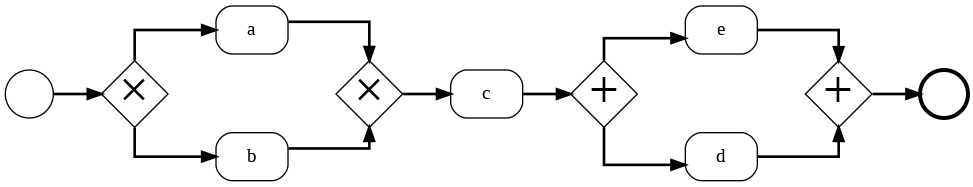

In [35]:
# A1

events = """b c d e 
b c e d 
a c d e 
a c e d 
"""

draw_graph(events)



Except


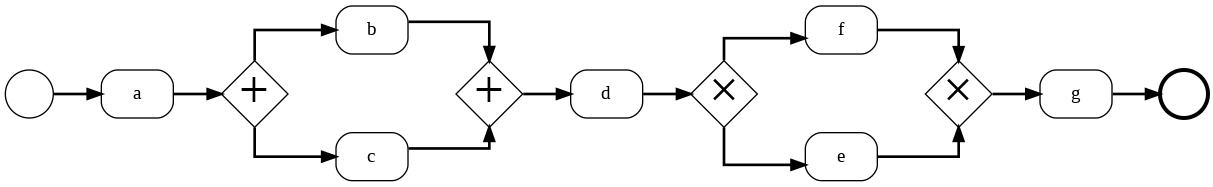

In [36]:
# A2
events = """a b c d e g 
a b c d f g 
a c b d e g 
a c b d f g 
"""

draw_graph(events)

Except
Except
Except
Except


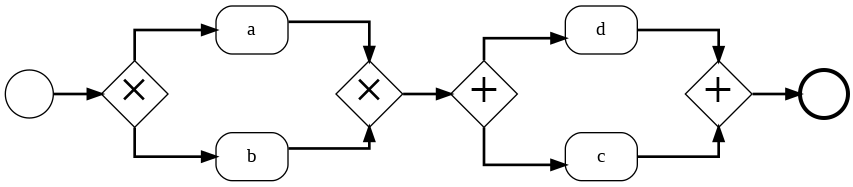

In [37]:
# A3
events = """a c d
a d c
b c d
b d c
"""

draw_graph(events)

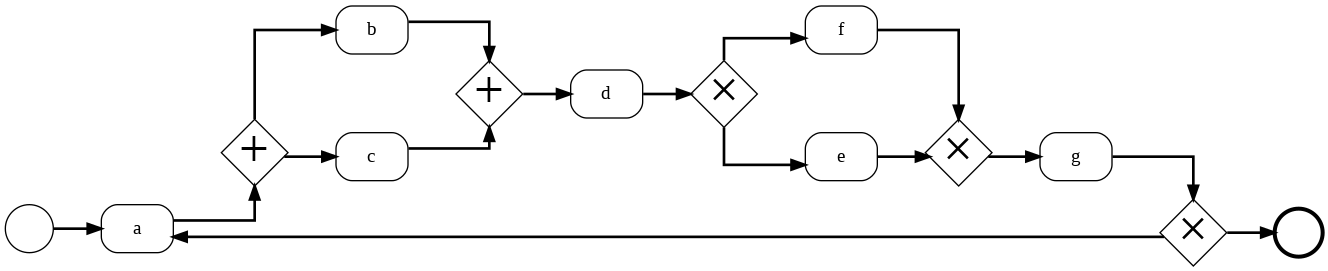

In [38]:
# A4
events = """a b c d e g 
a b c d f g 
a c b d e g 
a c b d f g 
a b c d e g a c b d f g 
a b c d f g a b c d f g 
a c b d e g a b c d e g 
a c b d f g a b c d e g 
a b c d f g a c b d e g 
"""

draw_graph(events)

Except


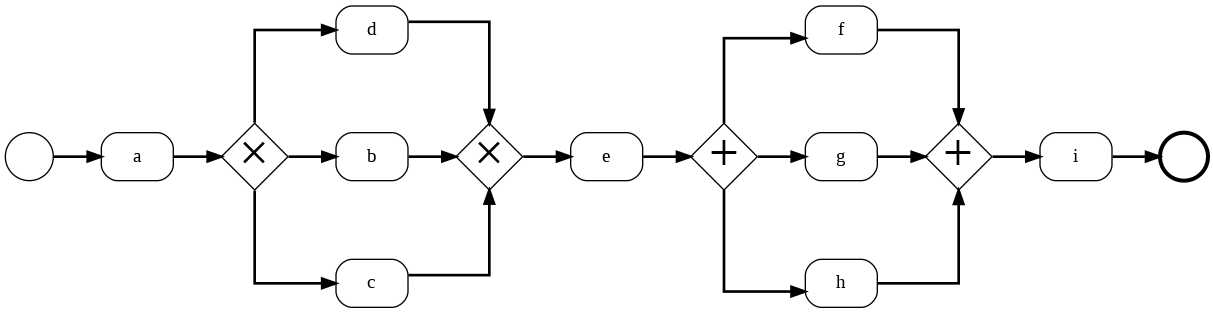

In [39]:
# A5
events = """a b e f g h i 
a c e f g h i 
a d e f g h i 
a b e f h g i 
a c e f h g i 
a d e f h g i 
a b e g f h i 
a c e g f h i 
a d e g f h i 
a b e g h f i 
a c e g h f i 
a d e g h f i 
a b e h g f i 
a c e h g f i 
a d e h g f i 
a b e h f g i 
a c e h f g i 
a d e h f g i 
"""

draw_graph(events)

Except


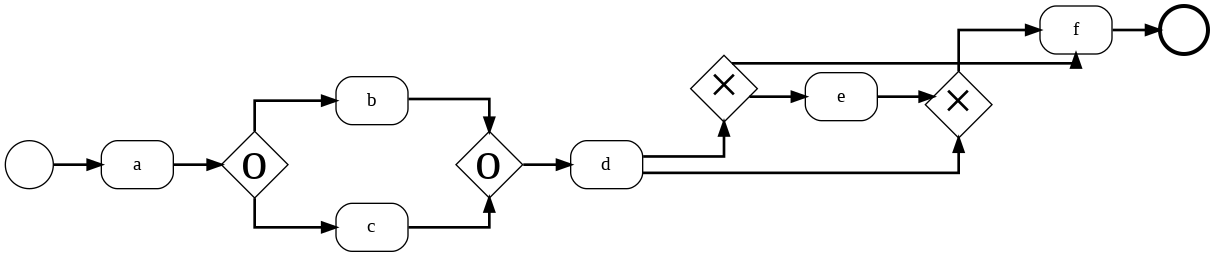

In [40]:
# A6
events = """a b c d e f 
a c b d e f 
a b c d f 
a c b d f 
a c d e f 
a b d e f 
a c d f 
a b d f 
"""

draw_graph(events)

Except
Except
Except
Except


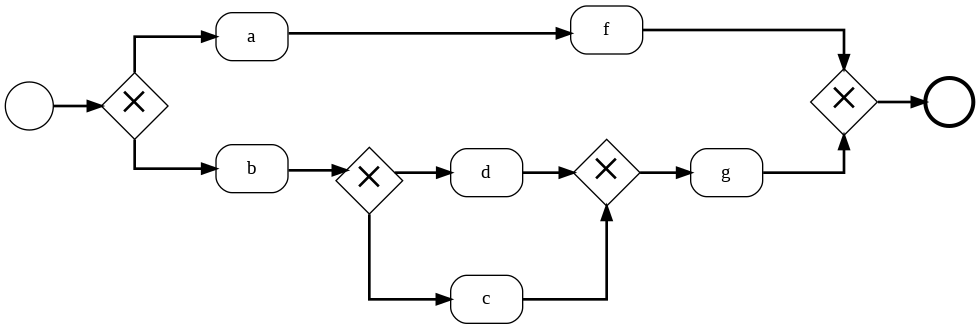

In [41]:
# A7
events = """a f b c g 
a f b d g 
a b f c g 
a b f d g 
a b c f g 
a b d f g 
a b c g f 
a b d g f 
b a f c g 
b a f d g 
b a c f g 
b a d f g 
b a c g f 
b a d g f 
b c a f g 
b d a f g 
b c a g f 
b d a g f 
b c g a f 
b d g a f 
"""

draw_graph(events)

Except


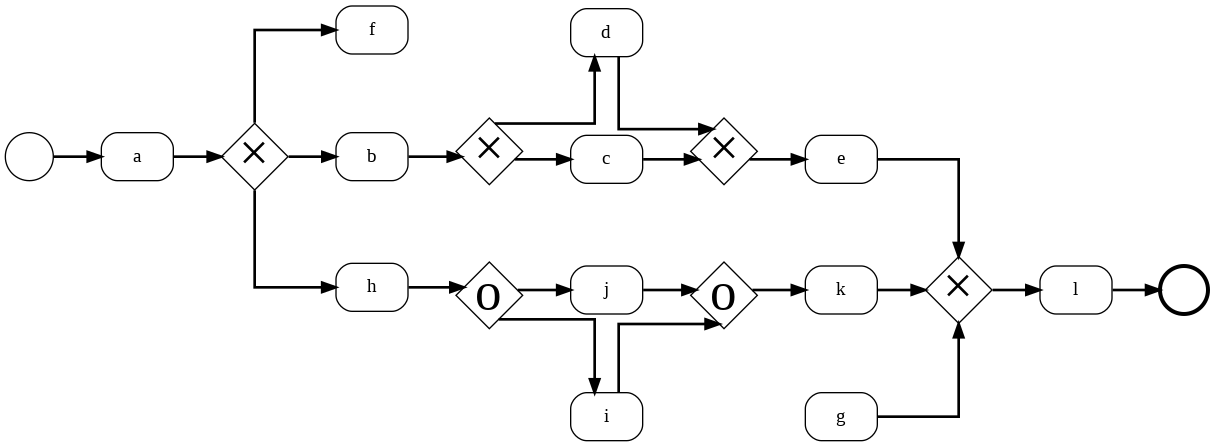

In [42]:
# A8
events = """a b c e l 
a b d e l 
a f g l 
a h i j k l 
a h j i k l 
"""

draw_graph(events)

Except


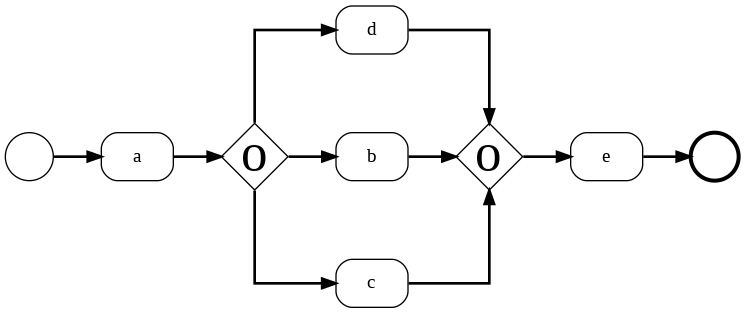

In [43]:
# A9
events = """a b c d e 
a b d c e 
a c b d e 
a c d b e 
a d b c e 
a d c b e 
a b c e 
a b d e 
a c b e 
a c d e 
a d b e 
a d c e 
a b e 
a c e 
a d e 
"""

draw_graph(events)

In [49]:
from opyenxes.data_in.XUniversalParser import XUniversalParser
import pandas as pd

file_name = "A1.csv"

f = open(file_name, "r")
if f.name.endswith('.csv'):
  print('csv')
  df = pd.read_csv(file_name)
elif f.name.endswith('.xes'):
  print('xes')
  with open(file_name) as log_file:
    # parse the log
    log = XUniversalParser().parse(log_file)[0]  
else:
  print('Nie rozpoznano pliku')

csv


In [50]:
# XES

event = log[0][0]
event.get_attributes()

{'Activity': <opyenxes.model.XAttributeLiteral.XAttributeLiteral at 0x7f0c2edf8090>,
 'concept:name': <opyenxes.model.XAttributeLiteral.XAttributeLiteral at 0x7f0c2edeaed0>,
 'lifecycle:transition': <opyenxes.model.XAttributeLiteral.XAttributeLiteral at 0x7f0c2edea850>,
 'time:timestamp': <opyenxes.model.XAttributeTimestamp.XAttributeTimestamp at 0x7f0c2edeafd0>}

In [51]:
events_xes = []
for trace in log: 
    events_w = []
    for event in trace[0::]:
        name = event.get_attributes()['Activity'].get_value()
        events_w.append(name)
    events_xes.append(events_w)

events_xes

[['b', 'c', 'd', 'e'],
 ['b', 'c', 'e', 'd'],
 ['a', 'c', 'd', 'e'],
 ['a', 'c', 'e', 'd']]

In [52]:
# CSV

df.head(100)

,Case ID,Activity,Start Timestamp
0,1,b,01.04.21 22:10
1,1,c,01.04.21 22:11
2,1,d,01.04.21 22:12
3,1,e,01.04.21 22:13
4,2,b,01.04.21 22:10
5,2,c,01.04.21 22:11
6,2,e,01.04.21 22:12
7,2,d,01.04.21 22:13
8,3,a,01.04.21 22:10
9,3,c,01.04.21 22:11


In [55]:
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

case_id = ''
start_time = ''
activity = ''

if (case_id == '' or start_time == '' or activity == ''):  
  for col in df.columns:
    if(len(df.columns)<3):
      print("Provided file cannot be used as an event log") 

    if(len(df.columns)==3):
      if (df[col].dtypes == 'int64'): 
        case_id = col
      elif (is_date(df.loc[0, col]) == True):
        start_time = col
      elif (df[col].dtypes != 'int64' and is_date(df.loc[0, col]) == False):
        activity = col
      else:
        case_id = input("Enter the name of id column: ")
        activity = input("Enter the name of activity column: ")
        start_time = input("Enter the name of timestamp column: ")

    if(len(df.columns)>3):
      if (df[col].dtypes == 'int64'): 
        case_id = col
      elif (is_date(df.loc[0, col]) == True):
        start_time = col
        activity = input("Enter the name of activity column: ")
      else:
        case_id = input("Enter the name of id column: ")
        activity = input("Enter the name of activity column: ")
        start_time = input("Enter the name of timestamp column: ")

print(start_time)
print(case_id)
print(activity)


Start Timestamp
Case ID
Activity


In [56]:
dfs = (df
    .sort_values(by=[case_id, start_time])
    .groupby([case_id])
    .agg({activity: ' '.join})    
)

dfs.head()

,Activity
Case ID,
1,b c d e
2,b c e d
3,a c d e
4,a c e d


In [57]:
events = dfs.Activity.tolist()
events_csv = []
for line in events:
    events_csv.append(line.split())

events_csv

[['b', 'c', 'd', 'e'],
 ['b', 'c', 'e', 'd'],
 ['a', 'c', 'd', 'e'],
 ['a', 'c', 'e', 'd']]

## Ćwiczenia rozszerzające model

1. Dopisz odpowiednie fragmenty kodu, tak aby móc uzyskać odpowiednie zbiory zdarzeń i relacje automatycznie. Sprawdź wynik dla poniższego przykładowego zbioru wariantów:

```
a b c d e h i k 
a b d c e h j k 
a f g h i k
```

```
direct_succession = {
    'a': {'b', 'f'},
    'b': {'c', 'd'},
    'c': {'d', 'e'},
    'd': {'c', 'e'},
    'e': {'h'},
    'f': {'g'},
    'g': {'h'},
    'h': {'i', 'j'},
    'i': {'k'},
    'j': {'k'}
}
```
2. Zastanów się nad uogólnieniem relacji na wiele zdarzeń, tzn. jak powinny być wykrywane bramy posiadające wiele przepływów wejściowych lub wiele przepływów wyjściowych, a także co w przypadku, gdy relacje dla wielu zdarzeń są różne.

  * Przetestuj swoje rozwiązanie na zestawie prostszych logów (zestaw A), które zostaną udostępnione na MS Teams. W sprawozdaniu proszę zamieścić wyniki działania rozwiązania dla całego zestawu.

3. Zintegruj odkrywanie relacji z dzisiejszych zajęć z minerem stworzonym w ramach poprzednich zajęć i rozszerz ich działanie. 

  * Przemyśl między innymi, jak powinno zachowywać się filtrowanie w przypadku wykrywanych relacji. 

  * Uwaga! Pamiętaj, że realne logi mogą dla algorytmu Alpha nie dawać sensownych rezultatów, ze względu na ograniczenia samego algorytmu. Ponadto przedstawiony sposób wizualizacji BPMN może być nieestetyczny w przypadku skomplikowanego układu bramek lub pętli.

4. Dodaj możliwość przesłania pliku dziennika zdarzeń w celu wykrycia procesu:

  * Automatyczne wykryj typ pliku logu (`csv`, `xes`) i załaduj odpowiednie dane z pliku. Plik `xes` w formacie XML można załadować np. biblioteką `opyenxes`.

  * W przypadku pliku `csv`, spróbuj dopasować ID przypadku, aktywność i znacznik czasu, lub jeśli nie są one dopasowane, poproś użytkownika o określenie odpowiednich kolumn.

5. Rozbuduj opracowany algorytm o wykrywanie dodatkowych relacji/konstrukcji z algorytmu Alpha+ (krótkie pętle: *self-loops* oraz *short-loops*). 

  * Przetestuj swoje rozwiązanie na zestawie prostszych logów (zestaw B), które zostaną udostępnione na MS Teams. W sprawozdaniu proszę zamieścić wyniki działania rozwiązania dla całego zestawu.

6. (*nadobowiązkowe*) Biblioteka używana do wizualizacji ma pewne ograniczenia, więc wyświetlany model BPMN nie zawsze będzie dobrze wyglądał. Osoby zainteresowane mogą zapoznać się z możliwościami rozbudowy swojego projektu poprzez:

  * Eksport diagramów BPMN w standaryzowanym formacie XML — można go zrealizować przy użyciu np. `bpmn-python` (https://github.com/KrzyHonk/bpmn-python).
  * Przygotowanie interaktywnej wizualizacji przy użyciu np. `pyvis` (https://pyvis.readthedocs.io/en/latest/index.html) albo `bpmn-js` (https://bpmn.io/toolkit/bpmn-js/).

Dzisiejszy temat jest przewidziany do realizacji przez 2 tygodnie zajęciowe, zatem kolejne zajęcia w marcu będą miały formę konsultacyjną. 

Zadania mogą być realizowane w parach, natomiast w sprawozdaniu należy podać wtedy imiona i nazwiska osób z pary oraz każda osoba powinna wysłać zadanie/sprawozdanie przez system MS Teams osobno. W sprawozdaniu należy umieścić odpowiednie zrzuty ekranu oraz kod źródłowy (fragment kodu ze zmianami). 
**Sprawozdanie z wykonanych ćwiczeń należy przesłać przez platformę MS Teams do 10.04.2021**. Sprawozdanie (pdf + kod w pliku py albo ipynb).


## Dodatkowe informacje

W razie potrzeby dodatkowych konsultacji proszę o informację lub ewentualne pytania e-mailowo, na messengerze albo na MS Teams. 

Dziękuję za udział w zajęciach! \\
Krzysztof Kluza \\
kluza@agh.edu.pl
